## DSC 672 Capstone: Update 3

## Ian Weimer, Brain Tumor CNN Modeling

## Mount to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/Dsc-project/'

import sys
sys.path.append(path)

Mounted at /content/gdrive


## Adjust Current Directory

In [ ]:
%cd gdrive/My Drive/'Dsc-project '

/content/gdrive/.shortcut-targets-by-id/1uJz7E2U3Q-UoOS38uopL_P796SlghVKR/Dsc-project


## Access Data

In [ ]:
%ls /content/gdrive/MyDrive/Dsc-project/

 1_Proposal/                          'DSC 672 Project Notes.gdoc'
 2_Update1/                            EDA/
 3_Update2_Group2/                    'Image Processing Slides - from IW'/
 4_Update3_Group2/                     Model_sav/
 5_DSC672_Project_Submission_Group2/  'Project Plan.gdoc'
 Data/                                 SK/
 Data2/                                SVM_Model_wProb.sav


## Import Packages

In [ ]:
from PIL import Image
import glob
import matplotlib.pyplot as plt
import cv2
import imutils
import numpy as np
import time
import seaborn as sns
import pandas as pd
import imageio
from sklearn.decomposition import PCA
from skimage import data
from skimage.color import rgb2gray
import keras
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D 
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import regularizers
from keras.layers import Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import os
from keras.callbacks import *
from keras.optimizers import RMSprop
import pathlib
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import accuracy_score
import itertools
print(tf.__version__)  # check the TF version!

2.5.0


## Load Data

In [ ]:
# original data loading
data_dir = path + 'Data/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Image Count: ",image_count)

Image Count:  3000


In [ ]:
# loading pre-split data
# Suresh split 70/30 and saved to files in drive
train_dir = path + 'SK/train'
train_dir = pathlib.Path(train_dir)
test_dir = path + 'SK/test'
test_dir = pathlib.Path(test_dir)
train_count = len(list(train_dir.glob('*/*.jpg')))
print("Training Image Count: ",train_count)
test_count = len(list(test_dir.glob('*/*.jpg')))
print("Testing Image Count: ",test_count)

Training Image Count:  2100
Testing Image Count:  900


## Train / Validation Split

For this update, data was pre-split into training and testing data ahead of time, to make consistent for evaluation across all models. Thus, additional splitting is not needed here. The pre-split data is loaded.

In [ ]:
batch_size = 32
img_height = 200
img_width = 200

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2100 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


## Preprocessing

### Normalization

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

### Data Augmentation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN Model Creation

In [ ]:
# Model 1

model = Sequential()

model.add(Conv2D(32,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = (200,200,1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(2, activation = 'softmax'))

In [ ]:
# Model 2

reg_p = 1e-4

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

model.add(Conv2D(32,(5,5), activation = 'relu',
                 kernel_regularizer=regularizers.l2(reg_p), padding = 'same',
                   strides=(2,2), input_shape = (200,200,1)))

# did not see improvment with kernel regularization
# did not see improvement with tuning parameters: kernel dim, activation, padding, 
# strides, etc. vs. default 

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64,(5,5), activation = 'relu', 
                 kernel_regularizer=regularizers.l2(reg_p),
                 padding = 'same', strides=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128,(5,5), activation = 'relu',
                 kernel_regularizer=regularizers.l2(reg_p),
                 padding = 'same', strides=(2,2)))
model.add(Conv2D(128,(5,5), activation = 'relu',
                 kernel_regularizer=regularizers.l2(reg_p),
                 padding = 'same', strides=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(256,(5,5), activation = 'relu',
                 kernel_regularizer=regularizers.l2(reg_p),
                 padding = 'same', strides=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(2, activation = 'softmax'))

In [ ]:
# model 3
# dropout and batch normalization actually made results worse on
# validation / testing data

num_classes=2

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes))

In [ ]:
# model 4

num_classes=2

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(num_classes))

## Compile Model

In [ ]:
model.compile(
  optimizer='adam', # found adam to be the superior optimizer 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Learning Rate Optimization

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 1e-5,
                              mode = 'min',
                              verbose=1)

## Fit, Evaluate Model

In [ ]:
history = model.fit(train_ds, validation_data = val_ds, epochs= 15, batch_size = 60, callbacks=[reduce_lr])

Epoch 1/15
66/66 [==============================] - 263s 3s/step - loss: 0.5924 - accuracy: 0.6920 - val_loss: 0.4202 - val_accuracy: 0.8078
Epoch 2/15
66/66 [==============================] - 2s 28ms/step - loss: 0.3410 - accuracy: 0.8622 - val_loss: 0.3336 - val_accuracy: 0.8444
Epoch 3/15
66/66 [==============================] - 2s 28ms/step - loss: 0.2091 - accuracy: 0.9170 - val_loss: 0.2468 - val_accuracy: 0.8844
Epoch 4/15
66/66 [==============================] - 2s 28ms/step - loss: 0.1225 - accuracy: 0.9622 - val_loss: 0.1515 - val_accuracy: 0.9544
Epoch 5/15
66/66 [==============================] - 2s 28ms/step - loss: 0.0741 - accuracy: 0.9799 - val_loss: 0.1338 - val_accuracy: 0.9578
Epoch 6/15
66/66 [==============================] - 2s 28ms/step - loss: 0.0384 - accuracy: 0.9835 - val_loss: 0.1081 - val_accuracy: 0.9644
Epoch 7/15
66/66 [==============================] - 2s 28ms/step - loss: 0.0255 - accuracy: 0.9940 - val_loss: 0.2887 - val_accuracy: 0.9300
Epoch 8/15
66

### Visualize Results

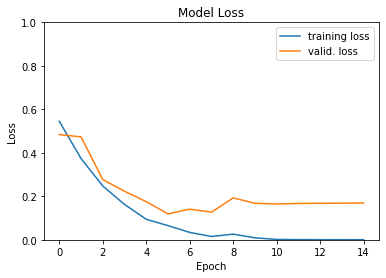

In [ ]:
plt.plot(history.history['loss'], label='training loss') # For TF2
plt.plot(history.history['val_loss'], label = 'valid. loss') # For TF2
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.title('Model Loss')
plt.legend(loc='upper right')

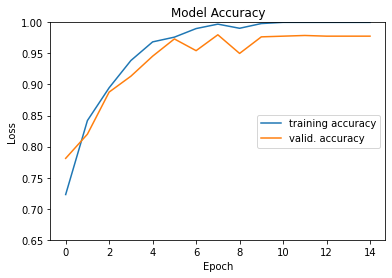

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy') # For TF2
plt.plot(history.history['val_accuracy'], label = 'valid. accuracy') # For TF2
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.65, 1])
plt.title('Model Accuracy')
plt.legend(loc='center right')

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 2 classes.


In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [ ]:
accuracy_score(labels, predictions)

0.9777777777777777

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(labels, predictions)
cf

array([[431,  12],
       [  8, 449]])

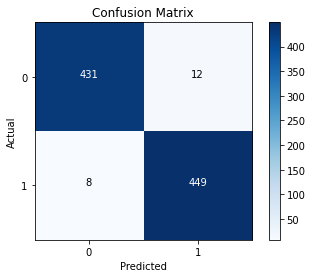

In [ ]:
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(labels))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

## Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0

## Test on Additional Data

In [ ]:
# loading additional dataset 
test2_dir = path + 'Data2/'
test2_dir = pathlib.Path(test2_dir)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test2_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

Found 253 files belonging to 2 classes.


In [ ]:
labels

array([0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0.

In [ ]:
predictions

array([0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0.

In [ ]:
accuracy_score(labels, predictions)

0.9802371541501976

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(labels, predictions)
cf

array([[ 96,   2],
       [  3, 152]])

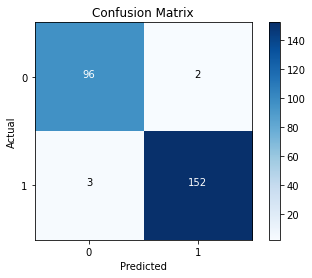

In [ ]:
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(labels))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

As seen above, the model did comparably well on the new dataset.